### Import Libraries

In [32]:
import pandas as pd
import numpy as np
import h5py
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
import string as st

# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

## Function

In [34]:
def preprocess_text(text):
    doc = nlp(text.lower().strip())  # Lowercase and remove whitespace
    
    # Remove stopwords, punctuation, and lemmatize
    tokens = [token.lemma_ for token in doc 
             if not token.is_stop and not token.is_punct and token.is_alpha]
    
    return ' '.join(tokens)

In [23]:
def extract_linguistic_features(text):
    doc = nlp(text)
    features = {
        'num_verbs': len([token for token in doc if token.pos_ == 'VERB']),
        'num_nouns': len([token for token in doc if token.pos_ == 'NOUN']),
        'sentence_length': len(doc),
        'blooms_verb_present': any(token.text in {'analyze', 'evaluate', 'create'} for token in doc)
    }
    return features

In [22]:
# Load dataset
df = pd.read_csv(os.getcwd().replace('notebook' , 'dataset') + '/question_dataset.csv')

# Apply preprocessing
df['processed_question'] = df['QUESTION'].apply(preprocess_text)

In [24]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=500)
X_tfidf = tfidf.fit_transform(df['processed_question'])

In [25]:
ling_features = df['processed_question'].apply(extract_linguistic_features).apply(pd.Series)
X_features = pd.concat([ling_features, pd.DataFrame(X_tfidf.toarray())], axis=1)

In [27]:
df.head(1)

,QUESTION,BT LEVEL,processed_question
0,"Suppose prices of two goods are constant, expl...",COMPREHENSION,suppose price good constant explain happen bud...


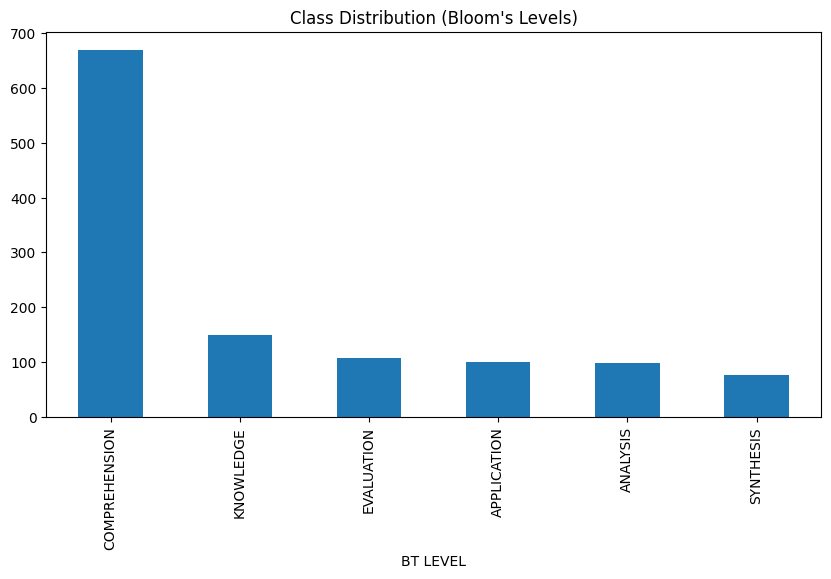

In [28]:
plt.figure(figsize=(10,5))
df['BT LEVEL'].value_counts().plot(kind='bar')
plt.title('Class Distribution (Bloom\'s Levels)')
plt.show()

In [35]:
tfidf = TfidfVectorizer()
tfidf_vect = tfidf.fit_transform(df['processed_question'])

In [38]:
tfidf_vect.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(1200, 2674))